In this notebook, we apply Incomplete Cholesky Decomposition on OKGT. The regularization is the same as that in our OKGT paper.

First, we simulate data from the model:

$$
Y = \ln (4 + \sin(4X_0)) + |X_1| + X_2^2 + X_3^3 + X_4 + 0.1\epsilon
$$

where $\epsilon \sim N(0,1)$ and each covariate is simulated from $Unif(-1,1)$.

We also specify the value of regularization term and the kernel functions for each variable (all Gaussian for now).

In [121]:
# Simulate data
import okgtreg.simulate as simulate
import okgtreg.kernel_selector as ks
import numpy as np
import scipy as sp
import pymc.gp.incomplete_chol as pyichol
from sklearn.metrics.pairwise import pairwise_distances

np.random.seed(10)
n = 500
y, x = simulate.SimData_Wang04(500)
y = np.matrix(y)
x = np.matrix(x)

# Regularization term
eps = 1e-6 

# Kernel functions
p = x.shape[1]
xGroup = [[i+1] for i in range(p)]
# kfn = ks.KernelSelector('Gaussian', sigma=5)
kfn = ks.KernelSelector('Laplace', alpha=0.005)
xkfnlist = [kfn]*p
ykfnlist = [kfn]

Secondly, we define some necessary functions to be used.

In [122]:
# Define the functions to be used
def ApplyICDonSymmetricMatrix(K, centerG=True):
    """
    Apply Incomplete Cholesky Decomposition on an uncentered Gram matrix.

    A Gram matrix K (n*n) assumes the following approximation:

        K \approx G * G^T
        G = U*S*V

    where G is a n*m matrix (m < n), which can be SVD decomposed. So U^T * U = I.

    So by combining them, we have:

        K \approx U * Lambda * U^T

    where Lambda = S^2, which is the m leading eigen values of K.

    Reference:
        2002, Bach and Jordan, Kernel Independent Component Analysis, Journal of Machine Learning Research

    :param K: numpy matrix, uncentered Gram matrix

    :param centerG: boolean, True by default.
        If True, G is centered. In particular, centered G will be used to approximate the centered K, i.e.

            (I - Ones/n) * K * (I - Ones/n) \approx G * G^T

        after permuting K according to pind.

    :return:
        U: numpy matrix, a n*m lower triangular matrix such that U^T * U = I.
        Lambda: 1-d numpy array, vector of m leading eigen-values of K.
        pind: 1-d numpy array of int32, vector of permutation indices, which are the column numbers of K in the same order as ICD retains them.
    """
    # Center the Gram matrix first then apply decomposition
    # if centerK:
    #     n = K.shape[0]
    #     I = np.matrix(np.identity(n))
    #     Ones = np.matrix(np.ones((n,n)))
    #     # K = np.einsum('ij, jk, lk', I - Ones/n, K, I - Ones/n) # slow
    #     K = (I - Ones/n) * K * (I - Ones/n)
    #     K = (K + K.T)/2 # force symmetry

    # ICD
    reltol = 1e-6
    L, m, pind = pyichol.ichol_full(K, reltol)
    G = np.matrix(L[:m].T)
    n = G.shape[0]

    if centerG:
        I = np.identity(n)
        Ones = np.matrix(np.ones((n, n)))
        G = (I - Ones/n) * G  # (column) centered G

    # SVD
    U, d, V = np.linalg.svd(G, full_matrices=False)
    Lambda = d**2 # eigen values of Gram matrix

    return U, Lambda, pind

def ReducedGramMatrix_ICD(x, kernel_fn):
        """
        Get U and Lambda from a Gram matrix.
        The Gram matrix is constructed from the given data and kernel function.

        :param x: numpy matrix.
                (part of) the data matrix. If it is the reponse y, then it is a n*1 matrix (one column).
                If it is the predictor, the number of columns of the matrix is the same as the size of a group.
                For example,
                    if x = (X_1, X_2), then it is a n*2 matrix.

        :param kernel_fn: callable returne from <KernelSelector>. It is a bivariate kernel function.

        :return:
            U: numpy matrix, a n*m lower triangular matrix such that U^T * U = I.
            Lambda: 1-d numpy array, vector of m leading eigen-values of K.
        """
        K = np.matrix(pairwise_distances(x, metric=kernel_fn))
        U, Lambda, pind = ApplyICDonSymmetricMatrix(K)
        return U, Lambda

def StackUandLambda(x, kernelFnsList, stackDiag=False, **kwargs):
        """
        Construct the row stack block matrix: [U_1, U_2, ..., U_l].

        :param x: numpy matrix. Design matrix for predictor variables.
        :param kernelFnsList: list of kernel functions, each is a callable returned from kernel_selector.KernelSelector.
        :param kwargs: additional keyword arguments.
                    If x is multivariate or high dimensional, provide the group information.
                    List of lists, same as <xGroup>.

        :return:
            numpy.matrix
            numpy.array
        """
        l = len(kernelFnsList)

        if l>1:
            U_list = []
            Lambda_list = []
            for i in range(l):
                ind = [a-1 for a in xGroup[i]] # variable indices for group i
                x_groupi = x[:,ind]
                U_i, Lambda_i = ReducedGramMatrix_ICD(x_groupi, kernelFnsList[i])
                # print Lambda_i
                U_list.append(U_i)
                Lambda_list.append(Lambda_i)
            
            URowStack = np.hstack(U_list)
            LambdaStack = np.hstack(Lambda_list)
            
            if stackDiag:
                UDiagBlock = sp.sparse.block_diag(U_list).todense()
                return URowStack, LambdaStack, UDiagBlock
            else:
                return URowStack, LambdaStack
        else:
            URowStack, LambdaStack = ReducedGramMatrix_ICD(x, kernelFnsList[0])
            return URowStack, LambdaStack

The derivation for the reduced-rank OKGT is given in a separate document. Basically, we need to contruct the covariance and cross-covariance with reduced-rank Gram matrices and proper regularization.

In [123]:
# Apply ICD, Centering, SVD.
# Also, stack some matrices together for future computation.
Ux, Lambdax, Ux_dblock = StackUandLambda(x, xkfnlist, stackDiag=True, xGroup=xGroup)
Uy, Lambday = StackUandLambda(y, ykfnlist)

mx = Ux.shape[1] # reduced dimension of X
my = Uy.shape[1] # reduced dimension of Y

In [124]:
mx

2437

If the dimension is high (large number of $X$), it will take long time to construct the above matrices. 

In [125]:
T = Ux * np.diag(Lambdax)
T = Uy.T * T
T = np.diag(Lambday / np.sqrt(Lambday**2 + eps)) * T

R = np.diag(Lambdax) * Ux.T * Ux * np.diag(Lambdax) + eps * np.identity(mx)
R_inv = np.linalg.inv(R)

eigval, eigvec = sp.linalg.eigh(T * R_inv * T.T, eigvals=(my-1,my-1))

The largest eigen value is the estimated $R^2$, and its square root is the estimated correlation between $g$ and $\sum f_i$.

In [126]:
print 'R^2 =', float(eigval)
print 'R =', float(np.sqrt(eigval))

R^2 = 0.484617734779
R = 0.696144909325


The above two values are almost the same as those by using the regularization in Bach&Jordan(2002), 0.819704193253  and 0.905375167129 respectively.

The eigen vector is used as the expansion loadings for the optimal transformation of Y, i.e.

In [127]:
# order of multiplication matters
g_opt = np.diag(Lambday) * np.matrix(eigvec)
g_opt = Uy * g_opt
# g_opt

The following is the plot of the transformation function $g(y)$:

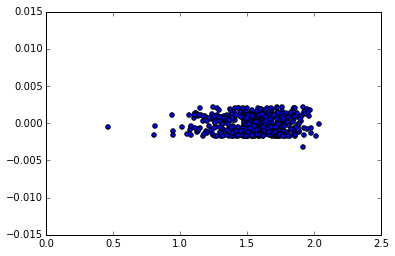

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(y, g_opt)

The optimal transformation of X is the projection of $g$ on the additive kernel space of $X$. 

In [108]:
f_opt = np.diag(np.sqrt(Lambday**2 + eps) * Lambday) * np.matrix(eigvec)
f_opt = T.T * f_opt
f_opt = R_inv * f_opt
f_opt = np.diag(Lambdax) * f_opt
f_opt = Ux_dblock * f_opt

f_opt = f_opt.reshape((n, p), order='F')
f_opt

matrix([[ 2.38607982, -3.06637995,  0.47107971, -3.20775479, -1.11941652],
        [-2.31008866, -2.21705779,  5.76995387,  0.09893479,  3.14141765],
        [ 2.50789253,  3.58688926,  3.54765692,  1.39960319, -5.70688407],
        ..., 
        [-6.55609541,  2.96752735,  4.225656  , -3.75699943, -1.5862087 ],
        [ 2.75072662, -0.23702056, -2.20781163,  2.81508442, -2.10212116],
        [-2.68258729,  3.58883745, -3.29998401, -1.05942375,  0.15731823]])

The Pearson correlation is:

In [109]:
print 'Pearson correlation =', float(sp.stats.pearsonr(g_opt, f_opt.sum(axis=1))[0])

Pearson correlation = 0.973291321762


The transformation functions are shown in the following plots:

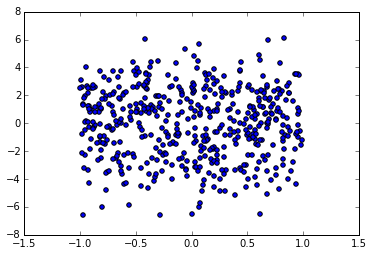

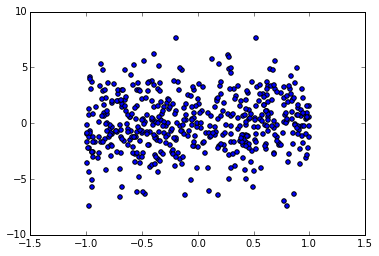

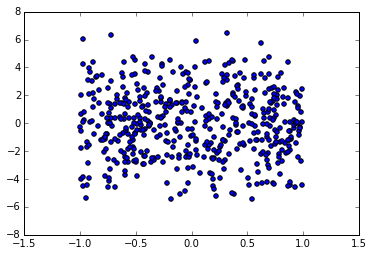

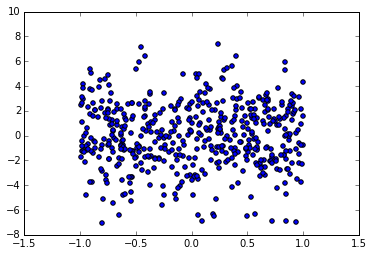

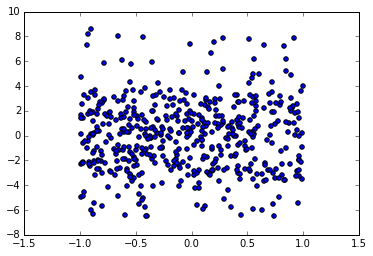

In [110]:
plt.figure()
plt.scatter(x[:,0], f_opt[:,0])
plt.show()

plt.figure()
plt.scatter(x[:,1], f_opt[:,1])
plt.show()

plt.figure()
plt.scatter(x[:,2], f_opt[:,2])
plt.show()

plt.figure()
plt.scatter(x[:,3], f_opt[:,3])
plt.show()

plt.figure()
plt.scatter(x[:,4], f_opt[:,4])
plt.show()